<a href="https://colab.research.google.com/github/LikeWind99/DeepLearning/blob/master/CHRGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip "/content/drive/MyDrive/dongman9005.zip" -d "/content/newdata"

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/newdata/faces/269b365a904734683332d4ac3581ced0-0.jpg  
  inflating: /content/newdata/faces/0e9903242aed0ee0ae664c05b2de667c-0.jpg  
  inflating: /content/newdata/faces/62729ebf137bf428beef7db0bd38083b-0.jpg  
  inflating: /content/newdata/faces/df5bf5f3c2146b88cfb934614218e973-0.jpg  
  inflating: /content/newdata/faces/f7faa586cb4c5d195268554d36860bbf-0.jpg  
  inflating: /content/newdata/faces/5107acda7da9d75fc3432247afa4d287-0.jpg  
  inflating: /content/newdata/faces/a683980b39c36f254f3e627b2d91630a-0.jpg  
  inflating: /content/newdata/faces/2bc07417b08d4dd5c60f5888dd6f87c4-1.jpg  
  inflating: /content/newdata/faces/d5749624205626026354de549b1d582c-1.jpg  
  inflating: /content/newdata/faces/e798121d02d01093d5026a03e4ccce71-0.jpg  
  inflating: /content/newdata/faces/9d20b4b2f0f36ca8075fd419ccb1095b-1.jpg  
  inflating: /content/newdata/faces/46c446984f45137194a575245d7b3899-0.jpg  
  inflating: /content/newdata/faces/bccc045de9c9f

('/content/newdata/faces/0000fdee4208b8b7e12074c920bc6166-0.jpg', 1)


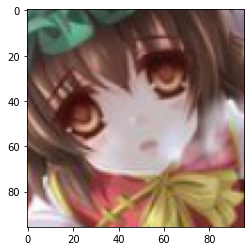

In [ ]:
import torch as t
import torch.nn as nn
import torchvision
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import os
from torchvision import transforms as T
from PIL import Image, ImageFile
from torch.utils.data import DataLoader
from torch.utils import data
from torchvision.utils import save_image
import tqdm
from google.colab import files


%matplotlib inline
imgs = ImageFolder("/content/newdata")
print(imgs.imgs[0])
img = plt.imread(imgs.imgs[0][0])
plt.imshow(img)
plt.show()

In [ ]:
# config
ImageFile.LOAD_TRUNCATED_IMAGES = True
root = '/content/newdata/faces'
sample_dir = '/content/newdata/result'
batch_size = 64
num_workers = 2
ngf = 64
ndf = 64
nz = 100
device = t.device('cuda' if t.cuda.is_available() else 'cpu')
epochs = 200
d_step = 5
g_step = 1

In [ ]:
# load dataset
if not os.path.exists(sample_dir):
  os.mkdir(sample_dir)
class Data(nn.Module):
  def __init__(self, root):
    super(Data, self).__init__()
    self.imgs = [os.path.join(root ,img) for img in os.listdir(root)]
    self.transforms = T.Compose([
                   T.Resize(96),
                   T.CenterCrop(96),
                   T.ToTensor(),
                   T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])
  def __getitem__(self, index):
    img_path = self.imgs[index]
    data = Image.open(img_path)
    data = self.transforms(data)
    return data

  def __len__(self):
    return len(self.imgs)

dataset = Data(root)
dataloader = DataLoader(dataset=dataset, shuffle=True, num_workers=num_workers, batch_size=batch_size, drop_last=True)

In [ ]:
# create Generator
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.main = nn.Sequential(
        # 输入是一个nz维度的噪声，我们可以认为它是一个1 * 1 * nz的feature map
        nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
        nn.BatchNorm2d(ngf * 8),
        nn.ReLU(inplace=True),
        # 上一步的输出形状：(ngf*8) x 4 x 4

        nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 4),
        nn.ReLU(inplace=True),
        # 上一步的输出形状： (ngf*4) x 8 x 8

        nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 2),
        nn.ReLU(inplace=True),
        # 上一步的输出形状： (ngf*2) x 16 x 16

        nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf),
        nn.ReLU(inplace=True),
        # 上一步的输出形状：(ngf) x 32 x 32

        nn.ConvTranspose2d(ngf, 3, 5, 3, 1, bias=False),
        nn.Tanh()
        # 输出形状：3 x 96 x 96
    )
  
  def forward(self, x):
    return self.main(x)



In [ ]:
# create Discriminator
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(
        # 输入 3 x 96 x 96
        nn.Conv2d(3, ndf, 5, 3, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        # 输出 (ndf) x 32 x 32

        nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 2),
        nn.LeakyReLU(0.2, inplace=True),
        # 输出 (ndf*2) x 16 x 16

        nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 4),
        nn.LeakyReLU(0.2, inplace=True),
        # 输出 (ndf*4) x 8 x 8

        nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 8),
        nn.LeakyReLU(0.2, inplace=True),
        # 输出 (ndf*8) x 4 x 4

        nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()  # 输出一个数(概率)
    )

  def forward(self, x):
    return self.main(x).view(-1)


In [ ]:
D = Discriminator().to(device)
G = Generator().to(device)

criterion = nn.BCELoss()
optimizer_d = t.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_g = t.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))

# normalization
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

total_step = len(dataloader)
for epoch in range(epochs):
    for i, imgs in tqdm.tqdm(enumerate(dataloader)):
        
        real_imgs = imgs.to(device)
        true_labels = t.ones(batch_size).to(device)
        fake_labels = t.zeros(batch_size).to(device)
        ################################################################
        #  Train the discriminator
        ################################################################
        if i % d_step == 0:
          # 真图片
          outputs = D(real_imgs)
          d_loss_true = criterion(outputs, true_labels)
          true_score = outputs

          # 噪声 1 * 1 * nz
          z = t.randn(batch_size, nz, 1, 1).to(device)
          fake_imgs = G(z)
          outputs = D(fake_imgs)
          d_loss_fake = criterion(outputs, fake_labels)
          fake_socre = outputs
          d_loss = d_loss_true + d_loss_fake

          optimizer_d.zero_grad()
          optimizer_g.zero_grad()

          d_loss.backward()
          optimizer_d.step()
        
        ################################################################
        #  Train the generator
        ################################################################
        z = t.randn(batch_size, nz, 1, 1).to(device)
        fake_imgs = G(z)
        outputs = D(fake_imgs)
        g_loss = criterion(outputs, true_labels)

        optimizer_d.zero_grad()
        optimizer_g.zero_grad()

        g_loss.backward()
        optimizer_g.step()
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch}/{epochs}], Step [{i+1}/{total_step}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, D(x): {true_score.mean().item():.2f}, D(G(z)): {fake_socre.mean().item():.2f}')

    if (epoch+1) == 1:
        imgs = imgs.reshape(imgs.size(0), 3, 96, 96)
        save_image(denorm(imgs), os.path.join(sample_dir, 'real_images.png'))
    
    # Save sampled images
    fake_imgs = fake_imgs.reshape(fake_imgs.size(0), 3, 96, 96)
    save_image(denorm(fake_imgs), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))


    # Save the model checkpoints 
    if (epoch + 1) % 10 == 0:
        t.save(G.state_dict(), 'G.ckpt')
        t.save(D.state_dict(), 'D.ckpt')
        files.download(f'/content/newdata/result/fake_images-{epoch+1}.png')

11it [00:35,  3.50s/it]

KeyboardInterrupt: ignored

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>